In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
df = pd.read_csv('community_engagement_records.csv')
df['datetime_created_at'] = pd.to_datetime(df['created_at'])
df = df.sort_values(by='datetime_created_at', ascending=False)
df['modified_userlogin'] = df['Name'] + '-' + df['ecosystem'] + '-' + df['userlogin']
filtered_data = df[~df['author_association'].isin(["COLLABORATOR", "MEMBER", "OWNER"])]
filtered_data = filtered_data[filtered_data['usertype'].isin(["User"])]

filtered_data.describe()


,id,number
count,3.144010e+05,314401.000000
mean,1.342364e+09,30531.910137
std,1.387822e+08,23693.400075
min,1.107273e+09,1.000000
25%,1.230870e+09,10313.000000
50%,1.332643e+09,28155.000000
75%,1.465570e+09,48890.000000
max,1.583946e+09,101699.000000


In [20]:
ecosystem_results = {}

for ecosystem, group in filtered_data.groupby('ecosystem'):
    total_unique_contributors = 0
    contributors_with_more_than_1_prs = 0

    total_prs_by_contributors_with_more_than_1_prs = 0
    
    for name, group in group.groupby(['modified_userlogin']):
        total_unique_contributors += 1
        pr_count = len(group)
        if pr_count > 1:
            contributors_with_more_than_1_prs += 1
            total_prs_by_contributors_with_more_than_1_prs += pr_count
    
    percentage_with_subsequent_prs = (contributors_with_more_than_1_prs / total_unique_contributors) * 100
    
    average_subsequent_prs =  total_prs_by_contributors_with_more_than_1_prs /contributors_with_more_than_1_prs if contributors_with_more_than_1_prs > 0 else 0
    
    ecosystem_results[ecosystem] = {
        "PercentageWithSubsequentPRs": percentage_with_subsequent_prs,
        "AverageSubsequentPRs": average_subsequent_prs
    }

# Print the results for each ecosystem
for ecosystem, results in ecosystem_results.items():
    print(f"Ecosystem: {ecosystem}")
    print(f"Percentage of PRs with subsequent PRs: {results['PercentageWithSubsequentPRs']:.2f}%")
    print(f"Average number of subsequent PRs for users with more than one PR: {results['AverageSubsequentPRs']:.2f}\n")


Ecosystem: maven
Percentage of PRs with subsequent PRs: 34.23%
Average number of subsequent PRs for users with more than one PR: 10.56

Ecosystem: npm
Percentage of PRs with subsequent PRs: 21.88%
Average number of subsequent PRs for users with more than one PR: 5.56

Ecosystem: pypi
Percentage of PRs with subsequent PRs: 36.20%
Average number of subsequent PRs for users with more than one PR: 7.72

Ecosystem: rubygems
Percentage of PRs with subsequent PRs: 26.81%
Average number of subsequent PRs for users with more than one PR: 15.27



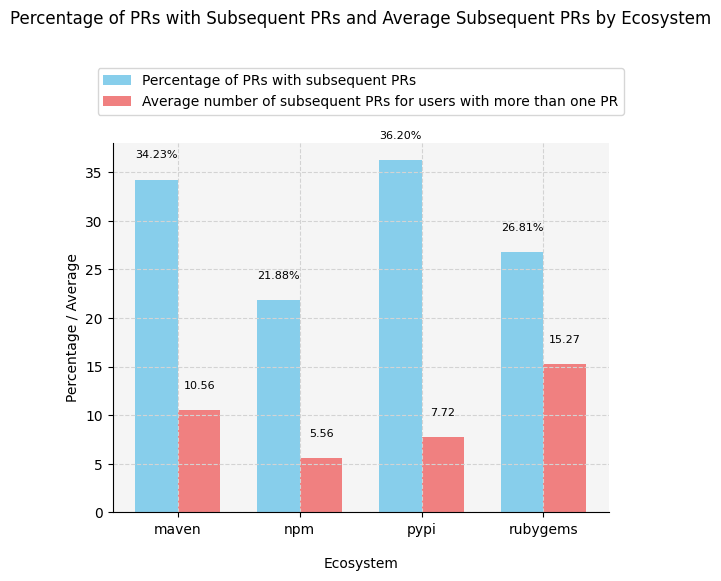

In [21]:

ecosystems = list(ecosystem_results.keys())
percentages = [results['PercentageWithSubsequentPRs'] for results in ecosystem_results.values()]
averages = [results['AverageSubsequentPRs'] for results in ecosystem_results.values()]

fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(ecosystems))

bar1 = ax.bar(index, percentages, bar_width, label='Percentage of PRs with subsequent PRs', color='skyblue')
bar2 = ax.bar(index + bar_width, averages, bar_width, label='Average number of subsequent PRs for users with more than one PR', color='lightcoral')

ax.set_xlabel('Ecosystem', labelpad=15)
ax.set_ylabel('Percentage / Average')
ax.set_title('Percentage of PRs with Subsequent PRs and Average Subsequent PRs by Ecosystem', y=1.3)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(ecosystems)

# Move the legend outside
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22))

# Add values inside the bars
for i, (val1, val2) in enumerate(zip(percentages, averages)):
    ax.text(i, val1 + 2, f'{val1:.2f}%', ha='center', va='bottom', fontsize=8)
    ax.text(i + bar_width, val2 + 2, f'{val2:.2f}', ha='center', va='bottom', fontsize=8)

# Create a background with lines of square size
background_color = '#f5f5f5'
ax.set_facecolor(background_color)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show grid lines
ax.grid(True, linestyle='--', color='lightgray')

plt.show()